# 4：Classification

响应变量是定性的(qualitative)、分类的。眼睛的颜色

分类（classiﬁcation）是什么？：预测定性响应变量的方法，它涉及将观测分配到一个类别中。

如何分类？
* logistic regression 逻辑斯蒂回归
* linear discriminant/Quadratic analysis 线性判别分析
* K-nearest neighbors. K近邻

## 4.1 分类问题概述：default.csv 信用卡违约数据
- 基于一个人的年收入（income）和月信用卡余额（balance）预测其违约的状态（default）

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import sklearn.metrics
import sklearn
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.gridspec as gridspec

In [3]:
#载入数据
plt.close('all')
file = pd.read_csv('/Users/yangchenxi/Desktop/量化投资与机器学习/4—分类/Default.csv',encoding='unicode_escape')
df = pd.DataFrame(file)
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [46]:
#描述性统计
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


/Applications/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


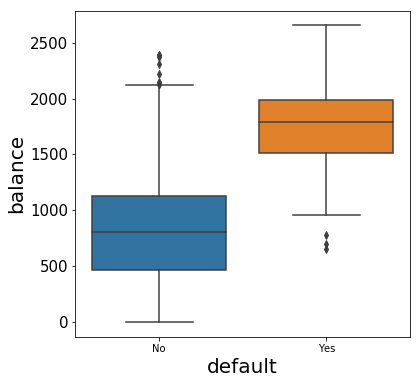

/Applications/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


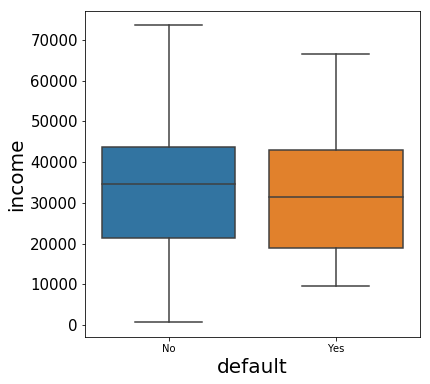

In [47]:
# bp2 = df.boxplot(by='default',column=['balance'])#画箱线图，
# plt.ylabel("Balance")
# bp3 =df.boxplot(by='default',column=['income'])
# plt.ylabel("Income")
import seaborn as sns
df1=df['default'].map({'Yes':1,'No':0})#先编码
plt.figure(figsize=(6,6))
sns.boxplot('default','balance',data=df)#x是违约情况default，y是balance
plt.ylabel('balance',fontsize=20.0)
plt.xlabel('default',fontsize=20.0)
plt.yticks(fontsize=15.0)
plt.show()

plt.figure(figsize=(6,6))
sns.boxplot('default','income',data=df)#x是违约情况default，y是income
plt.ylabel('income',fontsize=20.0)
plt.xlabel('default',fontsize=20.0)
plt.yticks(fontsize=15.0)
plt.show()

In [48]:
#图中显示，预测变量balance与响应变量default关系显著。违约用户比未违约用户倾向于拥有更多的信用卡余额。

## 4.2 为什么线性回归不可用?
根据患者的症状来预测他的患病情况
#### problem：
如果我们采用线性回归模型：


$$Y=\begin{cases}1,\ if\ stroke \\2,\ if\ drug overdose \\3 ,\ if\ epileptic seizure\end{cases}$$

* 把 **drug overdose 放在 stroke 和 epileptic seizure** 之间，表明 stroke 和 drug overdose 的差距与 drug overdose 和epileptic seizure的差距是一样的。默认了一个有序的输出。
###  哑变量(dummy variable)
对一个二元定性响应变量而言，可以利用哑变量方法对响应变量编码： 

$$Y\begin{cases}1,if \ stroke\\0,if \  drug \ overdose \end{cases}$$
然后对二元响应变量建立合适的线性回归模型，如果Y的估计值大于0.5，那么就预测为drug overdose，否则为stroke。

$$\hat{Y}\begin{cases}1,if \ \hat{Y}\ge 0.5 \\0,if \  \hat{Y}<0.5\end{cases}$$


对于一个0、1编码的二元变量，ols是有意义的，ols产生的估计Xβ实际上是Pr(drug overdose|X)的估计。但是，使用线性回归可能会使这个估计值在【0，1】范围外，这个数据很难被当作概率来解释。

### 但是，采用ols进行回归，如果有离群值，那么回归的函数容易受离群值影响，而且如果采用的是取平均的方式确定阈值，则离群值对阈值的影响也会比较大。

![title](fig1/1.png)

## 4.3 Logistic Regression
logistic regression 对Y属于某一类的概率建模而不直接对响应变量Y建模

eg.给定balance时的违约概率
$$Pr(default=Yes|balance)=p(balance)$$
### 4.3.1 The Logistic Model




#### ols的判别函数采用用线性的y = wx,而逻辑回归则采用sigmod函数,函数如下,其中z是多元线性回归中的W'X：
![title](fig/fig14.jpg)


![](fig1/2.png)



### 4.3.2 Multiple Logistic Regression
1. mechanism of MLE（极大似然估计）：最大似然估计会寻找关于参数的最可能的值（即，在所有可能的参数取值中，寻找一个值使这个采样的“可能性”最大化）。 
 
$$\ell\left(\beta_{0}, \beta\right)=\prod_{i: y_{i}=1} p\left(x_{i}\right) \prod_{i^{\prime}: y_{i^{\prime}}=0}\left(1-p\left(x_{i^{\prime}}\right)\right)$$



2.损失函数：真实值与预测值差别越大，Loss越大，我们的优化的目标就是减小Loss。
![title](fig/fig15.png)




In [49]:
#3.案例
y = df['default'].map({'Yes':1,'No':0})
X = df.loc[:,'balance']
X = sm.add_constant(X)#增加常数项
results = sm.Logit(y,X).fit()#进行拟合
results.summary()
#β1=0.0055，这表示信用卡余额越多，发生违约的概率就越大，也即是balance每增加一个单位，default的对数发生比就增加0.0055个单位。

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                  0.4534
Time:                        20:52:49   Log-Likelihood:                -798.23
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                6.233e-290
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6513      0.361    -29.491      0.000     -11.359      -9.943
balance        0.0055      0.000     24.952      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### 4.3.4 预测

In [50]:
#用学生身份（0、1）来预测违约概率
X = df['student'].map({'Yes':1,'No':0})
X = sm.add_constant(X)
results = sm.Logit(y,X).fit()
results.summary()
#哑变量的系数0.4049是正的，p值显著，表明学生身份比非学生身份更容易违约。
#balance的增长跟违约概率增长有联系。
#To be precise, a one-unit increase in balance is associated with an increase in the log odds of default by 0.0055 units.

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                0.004097
Time:                        20:52:50   Log-Likelihood:                -1454.3
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                 0.0005416
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5041      0.071    -49.554      0.000      -3.643      -3.366
student        0.4049      0.115      3.520      0.000       0.179       0.630
==============================================================================
"""

## LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)

### 参数介绍 
#### penalty惩罚项 
str, ‘l1’ or ‘l2’, 
默认: ‘l2’ 
注：在调参时如果我们主要的目的只是为了解决过拟合，一般penalty选择L2正则化就够了。但是如果选择L2正则化发现还是过拟合，即预测效果差的时候，就可以考虑L1正则化。另外，如果模型的特征非常多，我们希望一些不重要的特征系数归零，从而让模型系数稀疏化的话，也可以使用L1正则化。
#加上L1正则项（lasso回归）
#加上L2正则项（Ridge回归）

#### 正则化参数C 
smaller values specify stronger regularization

#### class_weight
用于标示分类模型中各种类型的权重，可以是一个字典或者’balanced’字符串，默认为不输入，也就是不考虑权重，即为None。

在分类模型中，我们经常会遇到两类问题：
#第一种是误分类的代价很高。比如对合法用户和非法用户进行分类，将非法用户分类为合法用户的代价很高，我们宁愿将合法用户分类为非法用户，这时可以人工再甄别，但是却不愿将非法用户分类为合法用户。这时，我们可以适当提高非法用户的权重。
#第二种是样本是高度失衡的，比如我们有合法用户和非法用户的二元样本数据10000条，里面合法用户有9995条，非法用户只有5条，如果我们不考虑权重，则我们可以将所有的测试集都预测为合法用户，这样预测准确率理论上有99.95%，但是却没有任何意义。这时，我们可以选择balanced，让类库自动提高非法用户样本的权重。提高了某种分类的权重，相比不考虑权重，会有更多的样本分类划分到高权重的类别，从而可以解决上面两类问题。


#### logistic回归需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和penalty(L2/L1)

正则化：如何去防止过拟合，首先想到的就是控制N的数量，即让N最小化，而让N最小化，其实就是让W向量中项的个数最小化

### 4.3.4 Multiple Logistic Regression
预测响应变量受多因素影响的情况

$$\log \left(\frac{p(X)}{1-p(X)}\right)=\beta_{0}+\beta_{1} X_{1}+\cdots+\beta_{p} X_{p}$$
$$p(X)=\frac{e^{\beta_{0}+\beta_{1} X_{1}+\cdots+\beta_{p} X_{p}}}{1+e^{\beta_{0}+\beta_{1} X_{1}+\cdots+\beta_{p} X_{p}}}$$




In [51]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [52]:
X.head()

,const,student
0,1.0,0
1,1.0,1
2,1.0,0
3,1.0,0
4,1.0,0


In [53]:
#多元logistic回归模型：结合balance、income、student三个预测变量建立的预测default概率
X = df.loc[:,'balance':'income']
Z = df['student'].map({'Yes':1,'No':0})
X = pd.concat([X, Z], axis=1)
X = sm.add_constant(X)
results = sm.Logit(y,X).fit()
results.summary()
#balance和哑变量student的p值很小：两者对default概率有影响
#哑变量student的系数为负，说明考虑到balance和income两个因素的作用，学生比非学生更不容易违约。
#遗漏变量。
#在使用一个预测变量做logistic回归时，如果其他预测变量与之有关系，那么预测模型会存在风险。
#遗漏变量。

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                  0.4619
Time:                        20:52:54   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                3.257e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance        0.0057      0.000     24.737      0.000       0.005       0.006
income      3.033e-06    8.2e-06      0.370      0.712    -1.3e-05    1.91e-05
student       -0.6468      0.236     -2.738      0.006      -1.110      -0.184
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### 4.3.5 响应分类数超过2的Logistic Regression
eg: 
急诊室里患者的患病情况分为三类: 
 $Pr(Y=stroke|X),\ Pr(Y=drug overdose|X)$, 
而$Pr(epileptic seizure|X)=1-Pr(Y=stroke|X)= Pr(Y=drug overdose|X)$

两类logistic模型可以推广至多类，但是实际应用中不常用，实际中常用判别分析。

##  4.4 线性判别分析（Linear Discriminant Analysis，LDA）

分别对每种响应分类 (给定的Y) 建立预测变量 X 的分布模型, 然后运用贝叶斯定理反过来去估计Pr(Y = k|X = x). 假设这些分布是正态分布时，模型在形式上与logistic回归很相似。

为什么有了logistic回归，还要用另一类方法？
* 当类别的区分度高的时候，logistic回归模型的参数估计不够稳定。
* 如果样本量n比较小，而且在每一类响应分类中预测变量X都近似服从正态分布，那么线性判别分析要比logistic回归更稳定。
* 正如4.3.5节提到, 当响应变量的分类多于两类时，线性判别分析应用更普遍.
### 4.4.1 运用贝叶斯定理进行分类

假设观测分成 K 类, K ≥ 2，即定性响应变量 Y 可以取 K 个不同的无序值

设$ \pi _{k}$为一个随机选择的观测来自第 k 类的先验概率（prior），也即是边缘概率，$ \pi _{k}$ = Pr(Y = k). 

设 $f_{k}\equiv Pr(X=x|Y=k)$ 表示第k类观测的X的密度函数。
贝叶斯定理(Bayes’theorem)可以表述为:
$$
Pr(Y=k|X=x)=\frac{\pi _{k}f_{k}(x)  }{ {\textstyle \sum_{l=1}^{K}\pi _{l}f_{l}(x)  } }=p_{k}(X)    (4.10)
$$
这种方法不需要直接计算 $p_{k}(X)$ , 我们可以将 $\pi _{k}$ 和 $f_{k}(X)$ 的估计值代入上述方程来计算. 
通常来说, $\pi _{k}$ 的估计是容易求得的：取一些变量Y的随机样本，分别计算属于第k类的样本占总样本的比例。
但对于 $f_{k}(X)$ 的估计要更复杂一些, 除非假设它们的密度函数形式很简单。

我们称 $p_{k}(X)$ 为 X = x 的观测属于第k类的后验(posterior)概率，即给定观测的预测变量值时，观测属于第k类的概率。

贝叶斯分类器将一个观测分到$p_{k}(X)$ 最大的一类中，它在所有分类器中错误率最小。因此，如果找到一个估计 $f_{k}(X)$的方法，则可以依此发展出一个与贝叶斯分类器类似的分类方法。

### 4.4.2 p = 1的线性判别分析
假设p = 1, 即只有一个预测变量。首先要获取 $f_{k}(x)$ 的估计，然后代入(4.10)中，从而估计出 $p_{k}(x)$。根据$p_{k}(x)$的值，将观测分到值最大的一类中。

为了估计 $f_{k}(x)$, 首先对其形式做一些假设：
假设$f_{k}(x)$是正态的（高斯的），在一维情况下的密度函数：
$$
f_{x} (x)=\frac{1}{\sqrt{2\pi}\sigma _{k}}exp(-\frac{1}{2\sigma _{k}^{2} }(x-\mu _{k} )^2 ) (4.11)
$$
再假设 $\sigma _{1}^{2}= \sigma _{2}^{2}=…=\sigma _{K}^{2}$: 即所有K个类的方差是相同的，简记为 $\sigma ^{2}$

代入得到:

$$
Pr(X=x|Y=k)=\frac{\pi _{k}\frac{1}{\sqrt{2\pi}\sigma }exp(-\frac{1}{2\sigma ^{2} }(x-\mu _{k} )^2 )  }{ {\textstyle \sum_{l=1}^{K}\pi _{l}\frac{1}{\sqrt{2\pi}\sigma }exp(-\frac{1}{2\sigma ^{2} }(x-\mu _{l} )^2 ) } }(4.12)
$$

贝叶斯分类器将观测 X = x 分到(4.12)最大的一类。对其取对数，可以看出贝叶斯分类器将观测分到δk(x)最大的一类，即：
$$
\delta _{k}(x)=x\cdot \frac{\mu _{k}}{\sigma^2}-  \frac{\mu _{k}^2}{2\sigma^2}+log(\pi_{k})(4.13)
$$
例如，假设 K = 2 且 $\pi_{1}=\pi_{2}$, 当 $2x(\mu_{2}-\mu_{2})>\mu_{1}^2-\mu_{2}^2$时, 贝叶斯分类器把观测分入第一类，否则分入第二类。此时贝叶斯决策边界对应的点为：

$$
x=\frac{\mu _{1}^2-\mu_{2}^2}{2(\mu_{1}-\mu_{2})}=\frac{\mu_{1}+\mu_{2}}{2}  (4.14)
$$
所以，事先知道每一类X都服从高斯分布，且分布中参数都已知，因此能直接计算贝叶斯分类器，但在实际情况中往往不能计算。

在实际中,即使很确定每一类 X 服从一个高斯分布, 但仍需估计参数$\ \mu_{1},..., \mu_{k},\pi_{1},...,\pi_{k},\sigma^2$。线性判别分析(LDA) 方法与贝叶斯分类器相似，将 $\pi_{k}, \mu_{k}, \sigma^2$ 代入。特别地，常常使用如下参数估计：
$$
\hat{\mu}_{k} =\frac{1}{n_{k} }\sum_{i:y_{i}=k}^{}x_{i}  
$$

$$
\hat{{\sigma}^2} =\frac{1}{n-K }\sum_{k=1}^{K}\sum_{i:y_{i}=k}^{}(x_{i}-\hat{\mu}_{k})^2  (4.15) 
$$

其中n为观测的总量,  $n_{k}$ 为属于第k类的观测。当每一类的先验概率信息不全时， LDA 用属于第k类观测的比例估计 $\pi_{k}$ ，即：
$$
\hat{\pi}_{k}=n_{k}/n(4.16)
$$
LDA分类器将估计值代入，并将观测X=x分入使下式最大的一类中：
$$
\hat{\delta} _{k}(x)=x\cdot \frac{\hat{\mu} _{k}}{\hat{\sigma}^2}-  \frac{\hat{\mu} _{k}^2}{2\hat{\sigma}^2}+log(\hat{\pi}_{k})(4.17)
$$
“线性”一词是由于判别函数中 $\hat{\delta}_{k}(x)$ 是x的线性函数，而不是x的一个复杂函数。
![title](fig/fig1.png)

### 4.4.3 p > 1的线性判别分析

现在将LDA分类器推广至多元预测变量的情况。假设 X = (X1, X2,…, Xp) 服从一个均值不同、协方差矩阵相同的多元正态分布。

多元高斯分布假设每一个预测变量服从一维正态分布且每两个预测变量之间存在一些相关性:
![title](fig/fig2.png)

为了表示一个p维随机变量X服从多元高斯分布,用以下符号表示 $X ∼ N(\mu, \sum)$. 密度函数可以定义为:
$$
f(x)=\frac{1}{(2\pi)^{p/2}|\sum|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1} (x-\mu) )(4.18)
$$
在预测变量的维度p>1的情况下，LDA分类器假设第k类观测服从一个多元高斯分布。将第k类的密度函数fk(X = x)代入(4.10)，可以知道贝叶斯分类器将观测X=x分入δk(x)最大的一类，
$$
\delta_{k}(x)=x^T\Sigma^{-1}\mu_{k}-\frac{1}{2}\mu_{k}^T\Sigma^{-1}\mu_{k}+log\pi_{k} (4.19)
$$
也即是(4.13)的向量形式。

下面的图形显示了一个例子:
![title](fig/fig3.png)
三个椭圆覆盖了其所属分布95%的数据，虚线是贝叶斯决策边界。这些边界上的x满足 $\delta_{k}(x) = \delta_{l}(x)$。也即是：
$$
x^T\Sigma^{-1}\mu_{k}-\frac{1}{2}\mu_{k}^T\Sigma^{-1}\mu_{k}=x^T\Sigma^{-1}\mu_{l}-\frac{1}{2}\mu_{l}^T\Sigma^{-1}\mu_{l}(4.20)
$$
for $k\neq l$. 


我们可以将LDA运用于Default数据上，根据一个人的信用卡余额和学生身份预测其违约情况。LDA模型对10000个训练样本进行拟合，得到训练错误率为2.75%。

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis#导入LDA
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,recall_score,accuracy_score

file=open('/Users/yangchenxi/Desktop/量化投资与机器学习/4—分类/Default.csv')
Default=pd.read_csv(file)
file.close()

#将哑变量编码
map_=pd.Series([0,1],index=['No','Yes'])
Default['var_student']=Default['student'].map(map_)
Default['var_default']=Default['default'].map(map_)

#得到训练集
X_train=Default[['balance','var_student']]#X是特征
y_train=Default['var_default']#y是目标值

#建立LDA模型
lda=LinearDiscriminantAnalysis().fit(X_train,y_train)#调用LinearDiscriminantAnalysis这个类，进行训练
score=lda.score(X_train,y_train)#回归模型的性能分数，就是利用R^2对拟合效果打分的
lda_after = lda.fit_transform(X_train,y_train)#lda可降维
print('error rate is: %.4f '%(1-score))
#X_train.shape
#lda_after.shape

error rate is: 0.0275 


这看上去是一个很低的错误率，但是要注意两点：
* 训练错误率往往比测试错误率要低，而后者才是建模的初衷。也就是说，如果用一个分类器去预测一个新个体是否会违约，可能效果会很糟糕。其中的原因是模型参数的调整过程中主要是使模型在训练数据上表现出较好的效果。参数p与样本总数n的比值越高，模型越容易出现过拟合。但在本例中p/n几乎为0，所以不需要担心这个问题。
* 在训练样本中只有3.33%的人违约，那么一个简单但无用的分类器：“不管每个个体是否是学生，不管每个个体的余额，总是预测这个个体不会违约”，也只会导致3.33%的错误率.也就是说，一个普通的null分类器也会达到仅比LDA错误率高一点点的效果。 

实际中，二元分类器可能会犯错误：将违约的人分入未违约的一类（假阴性）；将未违约的人分为违约（假阳性）。

In [55]:
#混淆矩阵
#行是预测违约情况，列是真实违约情况
def confusion_table(column='pred_default'):
    res=pd.DataFrame({})#创建一个空的数据帧
    list_=[]
    for i in [0,1]:
        for j in [0,1]:    
            list_.append(len(Default[(Default[column]==j) &
                                 (Default['var_default']==i)]))#计算真实违约情况为i，预测违约情况为j（0或1）的样本数，用len统计
        list_.append(list_[0]+list_[1])#计算真实违约为i的总样本数。得到一个列表，分别是“预测违约情况为0”、“预测违约情况为1”、“真实情况为i的情况下的样本数”
        res['%s'%i]=list_#res的第i行赋值为上述列表
        list_=[]#清空暂存变量list_
    res.index=['pred_0','pred_1','total']#设置行索引
    res.columns=['true_0','true_1']
    res['total']=res.apply(lambda x:x[0]+x[1],axis=1)#新增res的total一列，等于前两列之和
    return res

y_pred=lda.predict(X_train)#在训练集上预测
y_prob=lda.predict_proba(X_train)[:,1]#predict_proba(X_train)，返回预测属于某标签的概率
Default['pred_default']=y_pred
Default.head()

,default,student,balance,income,var_student,var_default,pred_default
0,No,No,729.526495,44361.625074,0,0,0
1,No,Yes,817.180407,12106.134700,1,0,0
2,No,No,1073.549164,31767.138947,0,0,0
3,No,No,529.250605,35704.493935,0,0,0
4,No,No,785.655883,38463.495879,0,0,0


In [56]:
confusion_table(column='pred_default')#混淆矩阵

,true_0,true_1,total
pred_0,9644,252,9896
pred_1,23,81,104
total,9667,333,10000


In [57]:
#也可采用sklearn中的 confusion_matrix 函数来得到混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred).T#第一个参数为样本真实的分类标签列表，第二个参数为样本预测的分类结果列表

array([[9644,  252],
       [  23,   81]])

In [58]:
def confusion_df(classifier,X_test,y_test):
    confusion=confusion_matrix(y_test,classifier.predict(X_test))
    res=pd.DataFrame(confusion.T,index=['pred_0','pred_1'],columns=['true_0','true_1'])
    return res
confusion_df(lda,X_train,y_train)#classifier采用lda。

,true_0,true_1
pred_0,9644,252
pred_1,23,81


In [59]:
#贝叶斯分类器，如果知道先验概率，高斯分布，就能转化成LDA，LDA是距离判别

分类在医学和生物学中也很重要，常用敏感性（sensitivity）和特异性（specificity）表征分类器或筛选测试的性能。

在本例中，敏感度是被正确判别的真正违约者的比例，在这种情况下为24.3%（81/333）。特异性是正确识别的非违约者的百分比，此处（1− 23/9, 667) × 100 = 99.8 %.

为什么LDA在对违约的客户进行分类方面做得这么差？换句话说，为什么它的灵敏度这么低？

正如我们所看到的，LDA试图逼近贝叶斯分类器，它在所有分类器中的总错误率最低（如果高斯模型是正确的）。贝叶斯分类器只是产生尽可能小的误差，而不管错误来自哪一类。但是信用卡公司则更希望避免把违约者错误分类。

贝叶斯分类器的原理是将观测分入后验概率pk(X)最大的一类中。当响应变量为二元时,如果
$$
Pr(default=Yes|X=x)>0.5(4.21)      那么就将观测分为“违约组”
$$

因此贝叶斯分类器，以及其扩展出来的LDA模型,采用50%作为后验违约概率的阈值，来将观测分入“违约组”。

如果我们现在更关心的是错误地将违约者判为未违约的概率，那么可以考虑降低阈值。

例如,如果有

$$
Pr(default=Yes|X=x)>0.2(4.22)，那么就可以纳入“违约组”
$$

The error rates that result from taking this approach are shown in the following table:

In [60]:
y_pred_lower_threshould=lda.predict_proba(X_train)[:,1]>0.2 #predict_proba返回预测属于某标签的概率,这里是一个逻辑表达式，>0.2就是True（分为违约组），否则为False
Default['pred2_default']=y_pred_lower_threshould#将Default添加一列，“是否高于阈值”，如果为True即分为“违约组”，False分为“非违约组”
confusion_table('pred2_default')#调用混淆矩阵

,true_0,true_1,total
pred_0,9432,138,9570
pred_1,235,195,430
total,9667,333,10000


下面的图形显示了改变后验违约概率阈值后，权衡利弊的结果。

## sklearn.metrics中的评估方法
### recall_score
召回率 =提取出的正确信息条数/样本中的信息条数。通俗地说，就是所有准确的条目有多少被检索出来了。
#形式：klearn.metrics.recall_score(y_true, y_pred, labels=None, pos_label=1,average='binary', sample_weight=None)


### accuracy_score
分类准确率分数是指所有分类正确的百分比。不能告诉你响应值的潜在分布，并且它也不能告诉你分类器犯错的类型。
#形式：sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
#normalize：默认值为True，返回正确分类的比例；如果为False，返回正确分类的样本数

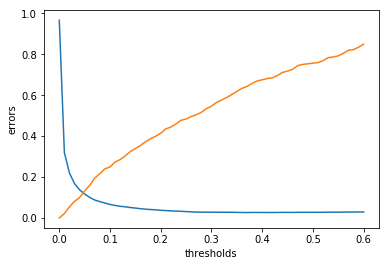

In [61]:
thresholds=[]#建立阈值列表
errors=[]#建立错误率列表
sensitivities=[]#建立灵敏度列表
for i in np.linspace(0.00,0.60,61):#创建一个等差数列
    y_pred_lower_threshould=lda.predict_proba(X_train)[:,1]>i #i为阈值，这个变量表示“是否高于阈值”，如果为True即分为“违约组”，False分为“非违约组”
    sensitivity=recall_score(y_train,y_pred_lower_threshould)#灵敏度：“被正确判别的违约者的比例”。也即是“召回率” =提取出的正确信息条数/样本中的信息条数。
    error=1-accuracy_score(y_train,y_pred_lower_threshould)# 1-分类准确率，就是分类的错误率。不会告诉你分类器犯错的类型。
    errors.append(error)#将每一个error值添加到errors列表中
    thresholds.append(i)
    sensitivities.append(sensitivity)
data=pd.DataFrame({'thresholds':thresholds,'errors':errors,'sensitivities':sensitivities})#创建数据帧
data['err_sensitivities']=1-data['sensitivities']# 1-灵敏度，就是“被错误判别的违约者的比例”

fig,ax=plt.subplots(1,1)
sns.lineplot(x='thresholds',y='errors',data=data,ax=ax)  #横轴是分类后验概率的阈值，纵轴是错误率
sns.lineplot(x='thresholds',y='err_sensitivities',data=data,ax=ax) #纵轴是灵敏度错误，也即是被错误判别的违约者的比率，把违约者分到非违约者。
plt.show()

可以看出，让总错误率越小，也即是蓝线越往右，这能降低总体错误的概率，但是“将违约者误判为不违约”的概率是增加的，这不是信用卡机构所希望的。

ROC曲线，能够同时展现出所有可能阈值出现的两种错误。
分类器的性能由ROC曲线下方的面积来表示（area under the ROC curve, AUC），该曲线能够涵盖所有可能的阈值。一个理想的ROC曲线会紧贴左上角，所以AUC越大，分类器越好。



如何画出ROC图：

(1) fpr, tpr, thresholds  =  roc_curve(y_test, scores) 

    其中y_test为测试集的结果，scores为模型预测的测试集得分（R^2)。计算fpr、tpr。thresholds就是模型预测值逆序排列后的结果

(2) roc_auc =auc(fpr, tpr) 

    roc_auc为计算的auc的值。

<Figure size 432x288 with 0 Axes>

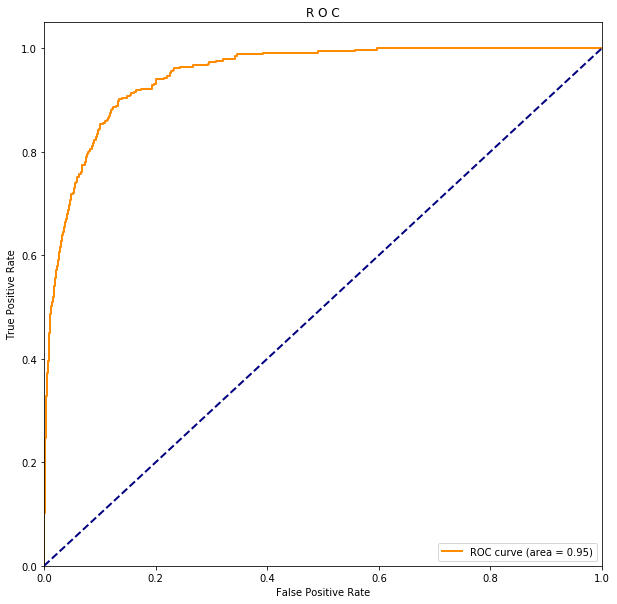

In [62]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
fpr,tpr,thresholds=roc_curve(y_train,y_prob)#计算fpr、tpr
roc_auc =auc(fpr, tpr)#计算auc的值

plt.figure()
lw = 2 #线条宽度
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###fpr为横坐标，tpr为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('R O C')
plt.legend(loc="lower right")
plt.show()
#分类器贴近左上角，即高的真阳性率，低的假阳性率，这是比较好的。

In [63]:
roc_auc #分类器表现良好

0.9495584339900053

### 4.4.4 Quadratic Discriminant Analysis

正如我们所讨论的，LDA假设每一类观测服从多元高斯分布，协方差矩阵相同。二次判别分析（QDA）提供了另一种方法。
与LDA一样，QDA分类器的结果是假设每个类别的观测值来自高斯分布，并将参数估计代入贝叶斯定理以进行预测。
然而，与LDA不同，QDA假设每个类别都有自己的协方差矩阵。也就是说，它假设来自第k类的观察结果的形式为
$X \sim N(\mu_{k}, \Sigma_{k})$,  $\Sigma_{k}$ 是第k类的协方差矩阵。
#在这种假设下，贝叶斯分类器把$X = x$ 分入使得其最大的一组：

$$
\delta_{k}(x)=x^T\Sigma^{-1}\mu_{k}-\frac{1}{2}\mu_{k}^T\Sigma_{k}^{-1}\mu_{k}+log\pi_{k}(4.23)
$$

#所以QDA分类器涉及把$\Sigma_{k}, \mu_{k}$, $\pi_{k}$ 的估计值代入(4.23)。 (4.23)是关于x的二次函数，所以称为QDA。

QDA估计协方差矩阵时需要的参数更多，但是，如果LDA的协方差矩阵相同的假设是一个糟糕的假设，那么LDA会产生很大的偏差。
一般而言，如果训练观测数据量相对较少，LDA比QDA更好；如果训练集更大，则更倾向于使用QDA，协方差矩阵相同的假设往往存在问题。


下图分两种情况说明了LDA和QDA的效果。在左图，两个类X1和X2有相同的相关系数0.7，且服从高斯分布。


![title](fig/fig11.png)

PS:The Bayes (purple dashed), LDA (black dotted), and QDA (green solid)


## 4.5 分类方法的比较

Logistic回归、LDA、QDA、KNN


LDA：

$$
log(\frac{p_{1}(x)}{1-p_{1}(x)} )=c_{0}+c_{1}x(4.24)
$$

 $c_{0}$ ， $c_{1}$ 是 $\mu_{1}, \mu_{2}$,  $\sigma^2$的函数

Logistic Regression：

$$
log(\frac{p_{1}}{1-p_{1}} )=\beta_{0}+\beta_{1}x(4.25)
$$

(4.24) 和 (4.25) 都是x的线性函数. 因此，逻辑回归和LDA都产生一个线性决策边界。两种方法唯一的不同是β0、β1是由极大似然估计出来的，而c0，c1是通过估计的正态分布值和方差计算出来的。LDA和逻辑回归的结果是接近的，但是LDA假设观测服从协方差矩阵相同的高斯分布，如果这个假设满足，那么使用LDA更合适。

### K近邻的工作原理是：存在一个样本数据集合，也称作训练样本集，并且样本集中每个数据都存在标签，即我们知道样本集中每一数据与所属分类的对应关系。输入没有标签的新数据后，将新数据的每个特征与样本集中数据对应的特征进行比较，然后算法提取样本集中特征最相似数据（最近邻）的分类标签。一般来说，我们只选择样本数据集中前k个最相似的数据，这就是k-近邻算法中k的出处，通常k是不大于20的整数。最后，选择k个最相似数据中出现次数最多的分类，作为新数据的分类。//KNN没有对决策边界的形状做假设，因此当决策边界高度非线性化的时候，该方法会优于LDA与逻辑回归。

QDA是在KNN和线性方法LDA、逻辑回归的一个折中的方法。QDA得到了一个二次的决策边界，所以比线性方法的应用更广。


---------------------------------------------------------------------------------------------------------------------------------------------


为了说明这四种分类方法的性能，我们从六种不同的场景生成了数据。在其中三种场景中，贝叶斯决策边界是线性的，而在其余场景中，贝叶斯决策边界是非线性的。对于每个场景，生成了100个随机训练数据集。在每个训练集上，分别用每种方法对对其进行拟合并在一个大的测试集上计算出结果的测试错误率。
![title](fig/fig12.png)
![title](fig/fig13.png)

6种情境中，预测变量个数p=2，这些情形如下：
* Scenario 1: 两类分别有20个观测。每一类的观测都是不相关的正态随机变量，且两类变量的均值不同。可以看出LDA表现良好。
* Scenario 2: 与情形一假设一样，知识每类中，两个预测变量的相关性为-0.5.结果与情形一相似。
* Scenario 3: 从t分布中产生X1和X2，每类50个观测。t分布和正态分布形状类似，但是倾向于产生更多极值点。这种情况下决策边界仍然是线性的，所以逻辑回归比较适合，但是由于不是正态分布所以LDA不适合。
* Scenario 4: 数据都由一个正态分布产生，在第一类中预测变量的相关系数为0.5，第二类中预测变量的相关系数为-0.5，这个假设与QDA假设相符合，并产生了二次的决策边界。
* Scenario 5: 观测来自正态分布，预测变量不相关，但预测变量的形式是X1^2,X2^2,X1*X2，所以这里有二次决策边界，QDA效果好。
* Scenario 6: 响应变量来自复杂的非线性函数，即使是QDA的二次决策边界也很难拟合好。KNN-CV较好，而K=1的时候的KNN反而不好，说明如果未能选择出一个恰当的光滑参数，KNN可能效果不好。

六个例子表明没有任何一种方法总是优于其他方法。当真实决策边界是线性的时候，LDA和逻辑回归较好；当边界是非线性，QDA较好。对更复杂的决策边界，KNN可能更好。

# LAB:Logistic Regression

In [5]:
# 1导入股票市场数据,df2：float,df3：string类型
df2 = pd.read_csv('Smarket.csv')
index=df2.columns
df3=pd.read_csv('Smarket.csv', dtype={'code':str})

In [65]:
df2.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


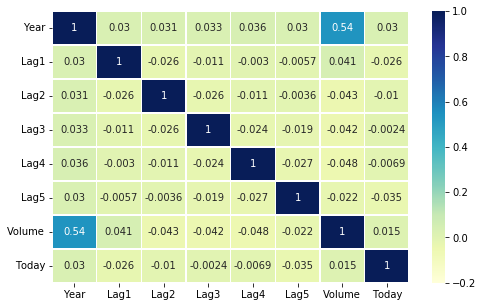

In [66]:
# 2观察相关性
corr = df2.corr() #方差协方差矩阵
plt.figure(figsize = (8,5))
sns.heatmap(corr,cmap="YlGnBu",annot=True,vmin=-0.2,linewidths=.5)#cmap指定颜色,annot=True在每个格子显示数值，vmin用于指定图例中最小值的显示值

In [67]:
df2.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


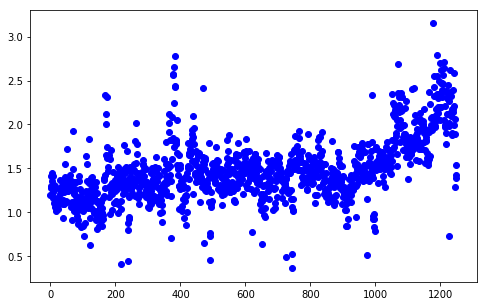

In [68]:
# 3画趋势图 https://github.com/matplotlib/matplotlib/issues/14603/
plt.figure(figsize = (8,5))
plt.scatter(df2.index,df2['Volume'],c="b")#c是指定颜色

In [69]:
# 4使用映射转化为二值变量
df2_orig = df2.copy()
y = df3['Direction'].map({'Down':0,'Up':1})#编码
X = df2.iloc[:,1:-2]#选择Lag1～Lag5、Volumn这几列
X = sm.add_constant(X)#加上截距项
results = sm.Logit(y,X).fit()#Logit回归
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                0.002074
Time:                        20:53:29   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
                                        LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.

In [70]:
#使用置信区间来计算系数的影响
params = results.params #提取所有参数
conf = results.conf_int() #各参数的置信区间
conf['OR'] = params #在conf这个数据帧添加一列，参数
conf.columns = ['2.5%', '97.5%', 'OR']#重命名
np.exp(conf)
conf

,2.5%,97.5%,OR
const,-0.597836,0.345836,-0.126000
Lag1,-0.171401,0.025254,-0.073074
Lag2,-0.140469,0.055866,-0.042301
Lag3,-0.086793,0.108963,0.011085
Lag4,-0.088589,0.107307,0.009359
Lag5,-0.086728,0.107354,0.010313
Volume,-0.174941,0.445822,0.135441


In [71]:
# 预测前10位
prob = results.predict(X)[0:10]#预测，选择概率最大的前十
predicted_classes = np.where(prob <=0.5,'Down','Up')#三个参数np.where(cond,x,y)：满足条件（cond）输出x，不满足输出y
pd.DataFrame({'Probabilities':prob,'Classes':predicted_classes})#以字典构建数据帧

,Probabilities,Classes
0,0.507084,Up
1,0.481468,Down
2,0.481139,Down
3,0.515222,Up
4,0.510781,Up
5,0.506956,Up
6,0.492651,Down
7,0.509229,Up
8,0.517614,Up
9,0.488838,Down


In [72]:
#confusion matrix.
#LogitResults.pred_table可以方便地用于获得一个“混淆矩阵”
table = results.pred_table(threshold=0.5)
table

array([[145., 457.],
       [141., 507.]])

In [73]:
# the fraction of days for which the prediction was correct:
(145+507)/1250
#预测的正确率

0.5216

## train & test

In [74]:
df2.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [75]:
# 选取test/train,Shape of train is (998, 9),Shape of test is  (252, 9)
del df2['Direction']
df2 = pd.concat([df2, y], axis=1)#将Direction替换成0或1，0表示Down，1表示Up
train = df2[df2['Year']<2005]#训练集选择2005年前的年份
test = df2[df2['Year'] >= 2005]
X_train = train.iloc[:,1:-2]#选择数据帧的几列，分别是Lag1～Lag5，Volumn
X_train = sm.add_constant(X_train)#增加常数项
X_test = test.iloc[:,1:-2]
X_test = sm.add_constant(X_test)
y_train = train['Direction']#y的训练集
y_test = test['Direction']

In [76]:
df2.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,1


In [77]:
results2 = sm.Logit(y_train,X_train).fit()#划分数据集后，选择训练集构建Logit模型
print(results2.summary())

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                  998
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            6
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                0.001562
Time:                        20:53:39   Log-Likelihood:                -690.55
converged:                       True   LL-Null:                       -691.63
                                        LLR p-value:                    0.9044
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1912      0.334      0.573      0.567      -0.463       0.845
Lag1          -0.0542      0.

In [78]:
pred_test = results2.predict(X_test)#测试
pred_test.head()

998     0.528220
999     0.515669
1000    0.522652
1001    0.513854
1002    0.498334
dtype: float64

In [79]:
accuracy2 = accuracy_score(y_test,pred_classes)#分类准确率分数是指所有分类正确的百分比。不能告诉你响应值的潜在分布，并且它也不能告诉你分类器犯错的类型。

In [80]:
pred_classes = np.where(pred_test > 0.5,1,0)#对测试结果编码，如果>0.5编码为1，否则编码为0
cm = confusion_matrix(y_test,pred_classes)#生成混淆矩阵
print("",pd.DataFrame(cm,columns = ['DOWN','UP'],index = ['DOWN','UP']))#打印
print("accuracy=",accuracy2)

       DOWN  UP
DOWN    77  34
UP      97  44
accuracy= 0.4801587301587302


### Performance on test set
| PRED\TRUE | Down | UP  |
|-----------|------|-----|
| DOWN      | 77  | 97  |
| UP        | 34  | 44|
accuracy=0.4802

测试的错误率高达52%，甚至不如随意猜测

### 只用Lag1和Lag2重新进行Logistic回归

In [81]:
predictors = ['Lag1','Lag2']
#重新设置x的训练集、测试集
X_train = train[predictors]
X_train = sm.add_constant(X_train)

X_test = test[predictors]
X_test = sm.add_constant(X_test)
# y的训练集和测试集保持不变

In [82]:
results3 = sm.Logit(y_train,X_train).fit()#Logit回归
pred_test3 = results3.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


In [83]:
pred_classes3 = np.where(pred_test3 > 0.5,1,0)#重新编码
cm3 = confusion_matrix(y_test,pred_classes3)#混淆矩阵
accuracy3 = accuracy_score(y_test,pred_classes3)#分类准确率分数

In [84]:
print("",pd.DataFrame(cm3,columns = ['DOWN','UP'],index = ['DOWN','UP']))
print("accuracy=",accuracy3)


       DOWN   UP
DOWN    35   76
UP      35  106
accuracy= 0.5595238095238095


| PRED\TRUE | Down | UP  |
|-----------|------|-----|
| DOWN      | 35   | 34  |
| UP        | 35   | 106 |
accuracy=0.5595

### 4.6.3 线性判别分析
Now we will perform LDA on the Smarket data. We fit the model using only the observations before 2005.

In [85]:
file=open('Smarket.csv')
Smarket=pd.read_csv(file)
file.close()
Smarket=Smarket.set_index('Year')#以Year为行索引

#设置X、y的训练集和测试集
data_train=Smarket[Smarket.index<2005]
y_train=data_train['Direction']
X_train=data_train[['Lag1','Lag2']]

data_test=Smarket[Smarket.index==2005]
y_test=data_test['Direction']
X_test=data_test[['Lag1','Lag2']]

lda=LinearDiscriminantAnalysis().fit(X_train,y_train)#使用训练集构建lda模型
classes=lda.classes_
priors=lda.priors_#先验概率
means=lda.means_#一个数组，依次给出了每个类别的均值向量
coef=lda.coef_
print('Prior probabilities of groups :')
print(classes)
print(priors)
print('Group means: (index=[Down,Up]),columns=[Lag1,Lag2]')
print(means)
print('Coeffficients: ')
print(coef)

Prior probabilities of groups :
['Down' 'Up']
[0.49198397 0.50801603]
Group means: (index=[Down,Up]),columns=[Lag1,Lag2]
[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
Coeffficients: 
[[-0.05544078 -0.0443452 ]]


In [86]:
y_pred=lda.predict(X_test)#通过X的测试集进行预测得到的y
print(confusion_df(lda,X_test,y_test))#混淆矩阵
print('Accuracy is: {}'.format(accuracy_score(y_test,y_pred)))#分类准确率分数

        true_0  true_1
pred_0      35      35
pred_1      76     106
Accuracy is: 0.5595238095238095


Applying a 50% threshold to the posterior probabilities allows us to recreate the predictions.

In [87]:
y_pred_threshould=(lda.predict_proba(X_test)>=0.5)[:,0]#生成True、False的array
print(y_pred_threshould.sum())#求和可得到True的个数
y_pred_threshould=(lda.predict_proba(X_test)<0.5)[:,0]
print(y_pred_threshould.sum())

70
182


### 4.6.4 二次判别分析
QDA模型

In [88]:
qda=QuadraticDiscriminantAnalysis().fit(X_train,y_train)#根据训练集建立QDA模型
classes=qda.classes_
priors=qda.priors_
means=qda.means_

print('Prior probabilities of groups :')
print(classes)
print(priors)
print('Group means: (index=[Down,Up]),columns=[Lag1,Lag2]')
print(means)

Prior probabilities of groups :
['Down' 'Up']
[0.49198397 0.50801603]
Group means: (index=[Down,Up]),columns=[Lag1,Lag2]
[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]


In [89]:
y_pred=qda.predict(X_test)
print(confusion_df(qda,X_test,y_test))#混淆矩阵
print('Accuracy is: {}'.format(accuracy_score(y_test,y_pred)))##分类准确率分数

        true_0  true_1
pred_0      30      20
pred_1      81     121
Accuracy is: 0.5992063492063492


### 4.6.5 K近邻
工作原理是：存在一个样本数据集合，也称作训练样本集，并且样本集中每个数据都存在标签，即我们知道样本集中每一数据与所属分类的对应关系。输入没有标签的新数据后，将新数据的每个特征与样本集中数据对应的特征进行比较，然后算法提取样本集中特征最相似数据（最近邻）的分类标签。一般来说，我们只选择样本数据集中前k个最相似的数据，这就是k-近邻算法中k的出处，通常k是不大于20的整数。最后，选择k个最相似数据中出现次数最多的分类，作为新数据的分类。

In [90]:
# neighbor=1,accuracy=0.5
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)#根据最近的一个
model.fit(X_train,y_train)#使用训练集
pred_test4 = model.predict(X_test)#对X的测试集进行预测
accuracy_score(y_test,pred_test4)#分类准确率分数

#可以看出非常不准确

0.5

In [91]:
# neighbor=3,accuracy=0.5317460317460317
knn = KNeighborsClassifier(n_neighbors=3)#根据最近的3个
knn.fit(X_train,y_train)
pred_test4 = knn.predict(X_test)
accuracy_score(y_test,pred_test4)

#稍好一点

0.5317460317460317

In [92]:
# 交叉验证最合适邻居数量
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
score = cross_val_score(knn,X_test,y_test,scoring='accuracy',cv = 10) #评分标准 分类标准 cv就是分成几份
score.mean()


0.5324444444444444

### 4.6.6 Caravan Insurance Data


In [93]:
df4 = pd.read_csv('Caravan.csv')
index4=df4.columns
df5=pd.read_csv('Caravan.csv', dtype={'code':str})
#df5

In [94]:
# 简单的数据汇报
del df4['Purchase']
y = df5['Purchase'].map({'No':0,'Yes':1})
df4 = pd.concat([df4, y], axis=1)
df4.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256,0.059773
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996,0.237087
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000


In [95]:
# 切分数据集
X_test = df4.iloc[:1000,:]
X_train = df4.iloc[1000:,:]

y_train = X_train['Purchase']
y_test = X_test['Purchase']
del X_train['Purchase']
del X_test['Purchase']

In [96]:
#标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test=scaler.fit_transform(X_test)
X_train=scaler.fit_transform(X_train)

In [97]:
X_train

array([[ 1.2308091 , -0.27590228,  2.93614908, ..., -0.15427936,
        -0.08805137, -0.11780156],
       [ 0.13836043, -0.27590228, -2.12438559, ..., -0.15427936,
        -0.08805137, -0.11780156],
       [-1.11015233, -0.27590228,  1.67101541, ..., -0.15427936,
        -0.08805137, -0.11780156],
       ...,
       [ 0.68458477, -0.27590228,  0.40588175, ..., -0.15427936,
        -0.08805137, -0.11780156],
       [ 0.76261681, -0.27590228,  0.40588175, ..., -0.15427936,
        -0.08805137, -0.11780156],
       [ 0.68458477, -0.27590228,  0.40588175, ..., -0.15427936,
        -0.08805137, -0.11780156]])

In [98]:
# KNN, n_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [99]:
pred = knn.predict(X_test)
cm = confusion_matrix(y_test,pred)#混淆矩阵
print("KNN, n_neighbors = 1:\n accuracy",accuracy_score(y_test,pred))#分类准确率分数
print("",pd.DataFrame(cm,columns = ['No','Yes'],index = ['No','Yes']))

KNN, n_neighbors = 1:
 accuracy 0.88
       No  Yes
No   872   69
Yes   51    8


In [100]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
cm = confusion_matrix(y_test,pred)
print("KNN, n_neighbors = 3:\n accuracy",accuracy_score(y_test,pred))
print("",pd.DataFrame(cm,columns = ['No','Yes'],index = ['No','Yes']))

KNN, n_neighbors = 3:
 accuracy 0.926
       No  Yes
No   921   20
Yes   54    5


In [101]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
cm = confusion_matrix(y_test,pred)
print("KNN, n_neighbors = 5:\n accuracy",accuracy_score(y_test,pred))
print("",pd.DataFrame(cm,columns = ['No','Yes'],index = ['No','Yes']))

KNN, n_neighbors = 5:
 accuracy 0.937
       No  Yes
No   934    7
Yes   56    3
